# Import Packages

In [1]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import Data and Data Cleaning

In [2]:
ab = pd.read_csv("AB_NYC_2019.csv")

### Remove unhelpful variables
variable that does not make sense: id, latitude, longitude

categorical variables that have too many levels: name, host_id, host_name, neighbourhood, last_review

In [3]:
ab.drop(['id', 'name', 'host_id', 'latitude', 'longitude', 'host_name',
         'neighbourhood', 'last_review'], axis=1, inplace=True)
ab = ab[ab['price'] > 0]
ab.dropna(inplace=True)

# EDA

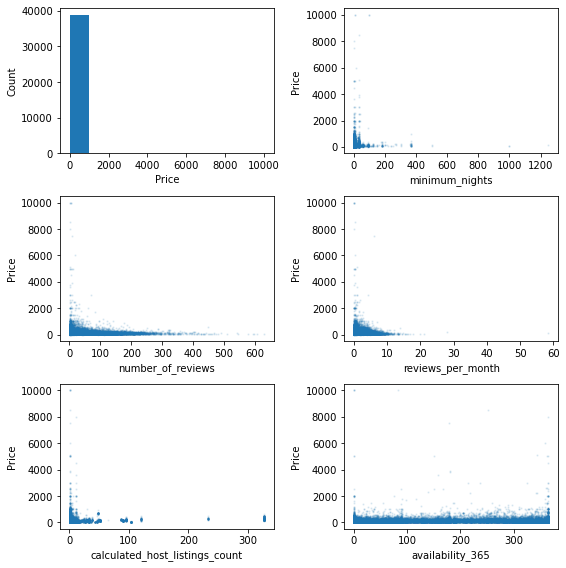

In [4]:
y = ab['price']
variables = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
             'calculated_host_listings_count', 'availability_365']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
axes = axes.flatten()

axes[0].hist(y)
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

for i, variable in enumerate(variables):
    axes[i+1].scatter(ab[variable], y, alpha=0.1, s=1.5)
    axes[i+1].set_xlabel(variable)
    axes[i+1].set_ylabel('Price')

plt.tight_layout()
plt.show()

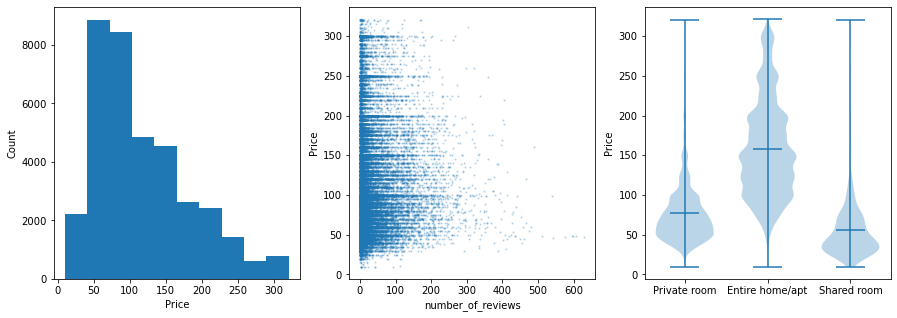

In [5]:
# Removed some outliers for performing better graphs
Q1 = np.quantile(ab.price, 0.25)
Q3 = np.quantile(ab.price, 0.75)
IQR = Q3 - Q1
bound = Q3 + 1.5*IQR
eda_ab = ab[ab.price <= bound]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].hist(eda_ab.price)
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

axes[1].scatter(eda_ab.number_of_reviews, eda_ab.price, alpha=0.2, s=1.5)
axes[1].set_xlabel('number_of_reviews')
axes[1].set_ylabel('Price')

room_pri = eda_ab[eda_ab["room_type"] == "Private room"]["price"].values
room_ent = eda_ab[eda_ab["room_type"] == "Entire home/apt"]["price"].values
room_sha = eda_ab[eda_ab["room_type"] == "Shared room"]["price"].values
axes[2].violinplot((room_pri, room_ent, room_sha), widths=0.7, showmeans=True)
axes[2].set_xlabel('')
axes[2].set_ylabel('Price')
label = (['Private room', 'Entire home/apt', 'Shared room'])
axes[2].set_xticks(np.arange(1, len(label)+1))
axes[2].set_xticklabels(label)

plt.show()

In [6]:
ab.groupby('neighbourhood_group')['price'].mean()

neighbourhood_group
Bronx             79.644571
Brooklyn         121.515209
Manhattan        180.052489
Queens            95.762571
Staten Island     89.964968
Name: price, dtype: float64

In [7]:
ab.groupby('room_type')['price'].mean()

room_type
Entire home/apt    196.303723
Private room        84.014384
Shared room         63.363744
Name: price, dtype: float64

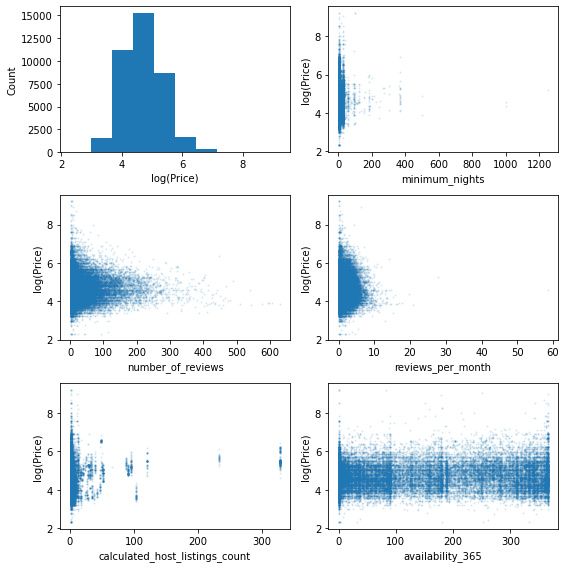

In [8]:
y = np.log(ab['price'])
variables = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
             'calculated_host_listings_count', 'availability_365']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
axes = axes.flatten()

axes[0].hist(y)
axes[0].set_xlabel('log(Price)')
axes[0].set_ylabel('Count')

for i, variable in enumerate(variables):
    axes[i+1].scatter(ab[variable], y, alpha=0.1, s=1.5)
    axes[i+1].set_xlabel(variable)
    axes[i+1].set_ylabel('log(Price)')

plt.tight_layout()
plt.show()

## Initial Model

In [9]:
model = smf.ols('price~neighbourhood_group+room_type+minimum_nights+number_of_reviews+reviews_per_month+calculated_host_listings_count+availability_365', data=ab).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     445.4
Date:                Wed, 09 Jun 2021   Prob (F-statistic):               0.00
Time:                        03:13:48   Log-Likelihood:            -2.5795e+05
No. Observations:               38833   AIC:                         5.159e+05
Df Residuals:                   38821   BIC:                         5.160e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


# Model diagonistics

## Multicolliearity

In [10]:
y, X = dmatrices('price~neighbourhood_group+room_type+minimum_nights+number_of_reviews+reviews_per_month+calculated_host_listings_count+availability_365',
                 data=ab, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                              features
0    48.660540                             Intercept
1    11.526440       neighbourhood_group[T.Brooklyn]
2    11.608185      neighbourhood_group[T.Manhattan]
3     5.499519         neighbourhood_group[T.Queens]
4     1.349427  neighbourhood_group[T.Staten Island]
5     1.051365             room_type[T.Private room]
6     1.027859              room_type[T.Shared room]
7     1.041810                        minimum_nights
8     1.470256                     number_of_reviews
9     1.488377                     reviews_per_month
10    1.068252        calculated_host_listings_count
11    1.132630                      availability_365


## Influential Points

In [11]:
influence = model.get_influence()
cooks_d = influence.cooks_distance
ab = ab[(cooks_d[0] <= 4/len(model.fittedvalues))]
model = smf.ols('price~neighbourhood_group+room_type+minimum_nights+number_of_reviews+reviews_per_month+calculated_host_listings_count+availability_365', data=ab).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     2022.
Date:                Wed, 09 Jun 2021   Prob (F-statistic):               0.00
Time:                        03:13:49   Log-Likelihood:            -2.2031e+05
No. Observations:               38402   AIC:                         4.407e+05
Df Residuals:                   38390   BIC:                         4.408e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


## Heteroskedasticity

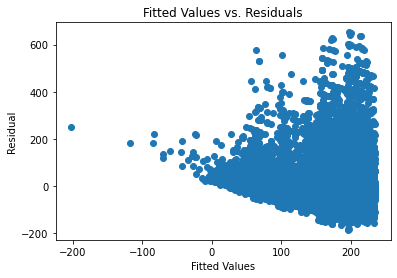

In [12]:
p = model.fittedvalues
res = model.resid
plt.scatter(p, res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
plt.show()

In [13]:
# Breusch-Pagan for Heteroskedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
# Heteroskedasticity exists

{'LM Statistic': 1619.816946392361, 'LM-Test p-value': 0.0}


### Remedy

In [ ]:
# log transformation on y
ab.loc[:, 'price'] = np.log(ab.loc[:, 'price']+1)

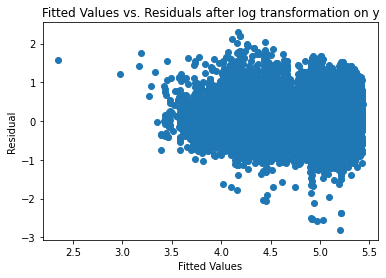

In [15]:
model_1 = smf.ols(
    'price~neighbourhood_group+room_type+minimum_nights+number_of_reviews+reviews_per_month+calculated_host_listings_count+availability_365', data=ab).fit()
p1 = model_1.fittedvalues
res1 = model_1.resid
plt.scatter(p1, res1)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after log transformation on y")
plt.show()

In [16]:
bp_test = het_breuschpagan(model_1.resid, model_1.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
# Heteroskedasticity still exists

{'LM Statistic': 498.50324785205004, 'LM-Test p-value': 6.687894297599302e-100}


### Use robust standard error

## Normality

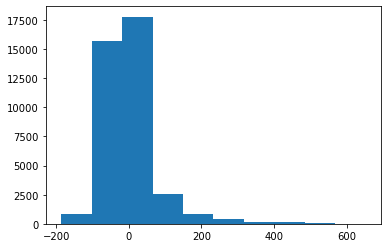

In [17]:
plt.hist(model.resid)
plt.show()

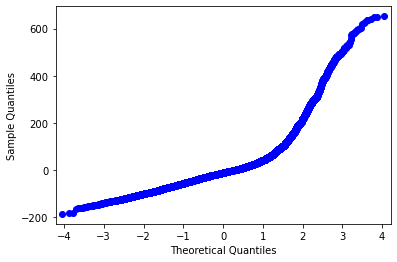

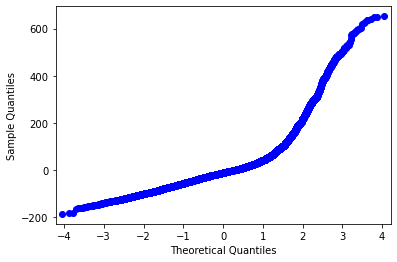

In [18]:
sm.qqplot(model.resid)

# Model Selection

In [19]:
Y = ab.price
X = ab.drop(columns='price', axis=1)
cp_list, R_squared_list, feature_list, aic_list, bic_list = [], [], [], [], []
numb_features = []
full_model = smf.ols(
    'price~neighbourhood_group+room_type+minimum_nights+number_of_reviews+reviews_per_month+calculated_host_listings_count+availability_365', data=ab).fit(cov_type='HC1')


def fit_model(variables):
    params = '+'.join(variables)
    model = smf.ols('price~{}'.format(params), data=ab).fit()
    n_params = len(model.params)
    n = len(model.fittedvalues)
    sse = model.mse_resid*(n - k)
    cp = (sse/full_model.mse_resid) - (n - 2*k)
    return model.rsquared_adj, cp, model.aic, model.bic


# Looping over k = 1 to k = 7 features in X
for k in range(1, len(X.columns) + 1):

    # Looping over all possible combinations: from 7 choose k
    for combo in itertools.combinations(X.columns, k):
        r2, cp, aic, bic = fit_model(list(combo))
        R_squared_list.append(r2)
        cp_list.append(cp)
        feature_list.append(combo)
        aic_list.append(aic)
        bic_list.append(bic)
        numb_features.append(len(combo))

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features, 'CP': cp_list, 'adj-R_squared': R_squared_list,
                   'features': feature_list, 'AIC': aic_list, 'BIC': bic_list})

In [20]:
df.sort_values('CP').head()

,numb_features,CP,adj-R_squared,features,AIC,BIC
100,5,4.843325,0.530642,"(neighbourhood_group, room_type, minimum_night...",43353.227092,43438.785740
120,6,5.006683,0.530652,"(neighbourhood_group, room_type, minimum_night...",43353.390028,43447.504541
121,6,6.833320,0.530629,"(neighbourhood_group, room_type, minimum_night...",43355.216954,43449.331467
126,7,7.000000,0.530640,"(neighbourhood_group, room_type, minimum_night...",43355.383214,43458.053592
102,5,44.764062,0.530154,"(neighbourhood_group, room_type, minimum_night...",43393.132449,43478.691097


### Choose model 100

In [21]:
print(df.iloc[100, 3])

('neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews', 'availability_365')


## Final Model with Robust Standard Error

In [22]:
final_model = smf.ols(
    'price~neighbourhood_group+room_type+minimum_nights+number_of_reviews+availability_365', data=ab).fit(cov_type='HC1')
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     5022.
Date:                Wed, 09 Jun 2021   Prob (F-statistic):               0.00
Time:                        03:14:05   Log-Likelihood:                -21667.
No. Observations:               38402   AIC:                         4.335e+04
Df Residuals:                   38392   BIC:                         4.344e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### Check Assumptions Again

In [23]:
y, X = dmatrices('price~neighbourhood_group+room_type+minimum_nights+number_of_reviews+availability_365',
                 data=ab, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

   VIF Factor                              features
0   48.214537                             Intercept
1   11.547139       neighbourhood_group[T.Brooklyn]
2   11.585747      neighbourhood_group[T.Manhattan]
3    5.538564         neighbourhood_group[T.Queens]
4    1.341999  neighbourhood_group[T.Staten Island]
5    1.049473             room_type[T.Private room]
6    1.027851              room_type[T.Shared room]
7    1.046649                        minimum_nights
8    1.057655                     number_of_reviews
9    1.094364                      availability_365


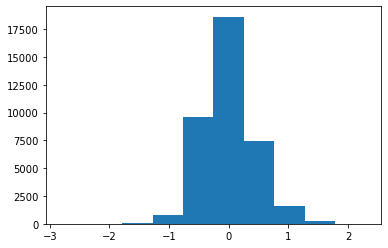

In [24]:
plt.hist(final_model.resid)
plt.show()

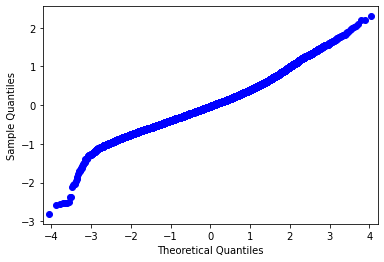

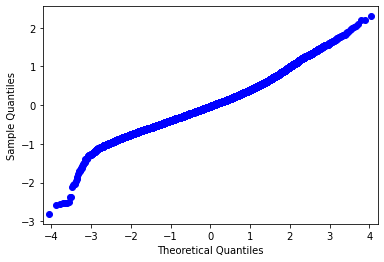

In [25]:
sm.qqplot(final_model.resid)